In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/home/efarr/Documents/GitHub/metalinks/Tests/Figures')
from aux import *
import matplotlib.gridspec as gridspec

In [2]:
DB = pd.read_csv('/home/efarr/Documents/BC/TestDBs/DB_F.csv')
DB['connection'] = DB['HMDB'] + '_' + DB['Symbol']
len(DB['connection'].unique())

10165

In [3]:
metalinks_data = load_prepro_metalinks(MR_path='/home/efarr/Documents/BC/TestDBs/DB_F.csv')
PD = metalinks_data[0]
MR = metalinks_data[1]
anno = metalinks_data[2]
data = load_prepro_other_dbs(MR, PD)
PD_metabolites = data[0]
MR_metabolites = data[1]
MR_proteins = data[2]
MR_interactions = data[3]

In [4]:
# BARPLOT
NeuronChatDB = [len(MR_interactions[0]), len(MR_metabolites[0]), len(MR_proteins[0])]
CellPhoneDB = [len(MR_interactions[1]), len(MR_metabolites[1]), len(MR_proteins[1])]
MebocostDB = [len(MR_interactions[2]), len(MR_metabolites[2]), len(MR_proteins[2])]
MetalinksDB = [len(MR_interactions[3]), len(MR_metabolites[3]), len(MR_proteins[3])]

# write the above as function that takes a list of lists as input
df = preprocess_data_for_barplot([NeuronChatDB, CellPhoneDB, MebocostDB, MetalinksDB], ['NCDB', 'CPDB', 'MDB', 'MLDB'], ['Interactions', 'Metabolites', 'Proteins'])
# HEATMAP

matrix = prepare_fractions(MR_metabolites, anno)

hm = prepro_hm(matrix[2])

/home/efarr/Documents/metalinks/Tests/Figures/aux.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others)
/home/efarr/Documents/metalinks/Tests/Figures/aux.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others)
/home/efarr/Documents/metalinks/Tests/Figures/aux.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others)
/home/efarr/Documents/metalinks/Tests/Figures/aux.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others)


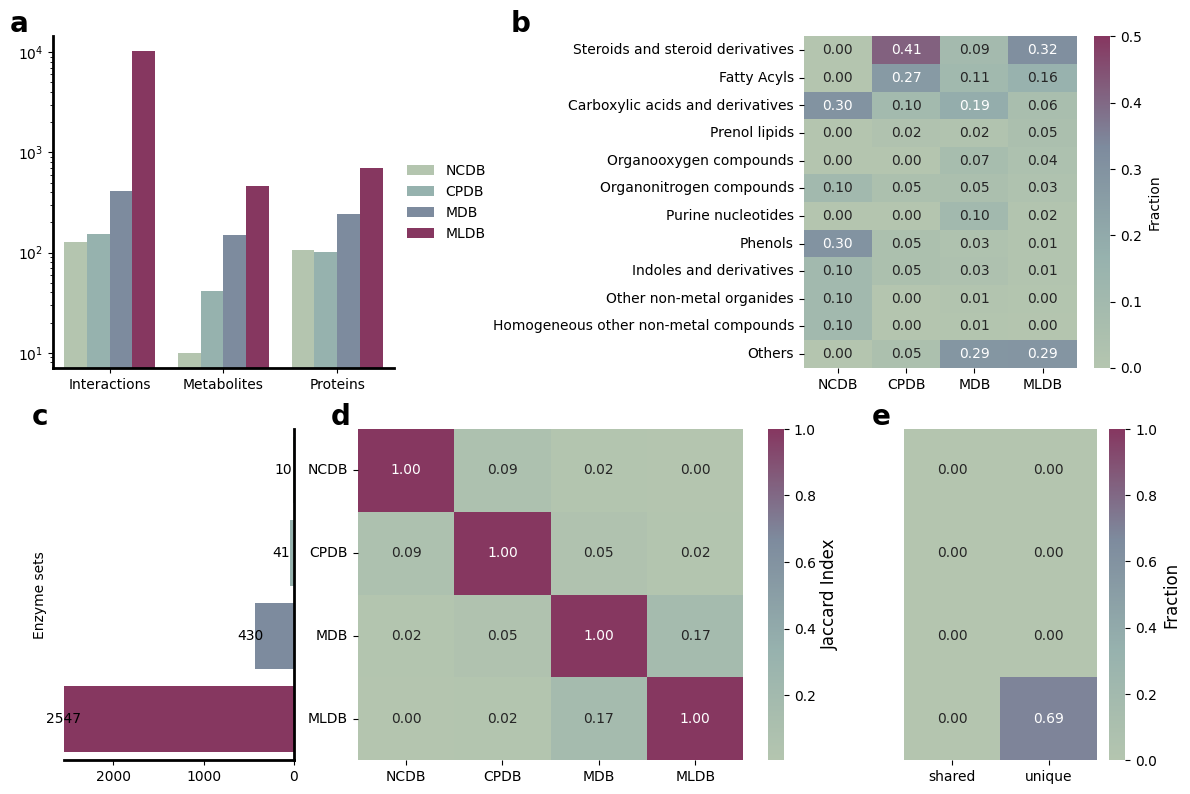

In [5]:
values = [len(x) for x in PD_metabolites]
matrix1 = get_jaccard(PD_metabolites)
matrix2 = count_shared_and_unique_metabolites(PD_metabolites)

def figure_2(df, hm, values, matrix1, matrix2, subject='Enzyme sets'):
    labels = ['NeuronChatDB', 'CellphoneDB', 'MebocostDB', 'MetalinksDB']
    row_labels = ['NCDB', 'CPDB', 'MDB', 'MLDB']
    col_labels = ['NCDB', 'CPDB', 'MDB', 'MLDB']
    data1 = np.array(matrix1)
    data2 = np.array(matrix2)
    
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,2])
    gs_upper = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0, 0], wspace=0.1, width_ratios=[1, 1, 1])
    gs_lower = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, 0], wspace=0.2, width_ratios=[1, 2, 1])

    colors = ['#B2C9AB', '#92B6B1', '#788AA3', '#932A61']
    color_list = ['#B2C9AB', '#92B6B1', '#788AA3', '#932A61']
    color_list_r = ['#932A61','#788AA3', '#92B6B1', '#B2C9AB']
    adjusted_colors = [sns.desaturate(c, 0.75) for c in color_list]
    cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', adjusted_colors)


    colormap = 'cividis'
    colormap = cmap_custom
    ax1 = plt.subplot(gs_upper[ 0])
    sns.barplot(data=df, x='index', y='Count', hue='Database', ax=ax1, palette=colors)
    ax1.set_yscale('log')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # remove box around the legend
    ax1.get_legend().get_frame().set_linewidth(0.0)

    ax6 = plt.subplot(gs_upper[1])
    # make a white plain for ax6
    ax6.axis('off') 

    ax2 = plt.subplot(gs_upper[0, 2])
    sns.heatmap(hm, annot=True, cmap=colormap, fmt='.2f', vmin=0, vmax=0.5, ax=ax2 )
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    cbar = ax2.collections[0].colorbar
    cbar.set_label('Fraction')

    ax3 = plt.subplot(gs_lower[0])
    sns.barplot(y=labels, x=values, orient='h', ax=ax3, palette=colors, saturation=0.75)
    ax3.grid(False)
    ax3.set_facecolor('white')
    for i, value in enumerate(values):
        ax3.text(value + 200, i, str(value), va='center', color='black')
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    ax3.spines['bottom'].set_bounds(0, max(values))
    ax3.invert_xaxis()
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_ylabel(subject)

    ax4 = plt.subplot(gs_lower[1])
    sns.heatmap(data1, annot=True, cmap=colormap, fmt='.2f', xticklabels=col_labels, yticklabels=row_labels, ax=ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
    ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)
    cbar1 = ax4.collections[0].colorbar
    cbar1.set_label('Jaccard Index', size=12)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_linewidth(2)
    ax4.spines['bottom'].set_linewidth(2)

    ax5 = plt.subplot(gs_lower[2])
    sns.heatmap(data2, annot=True, cmap=colormap, fmt='.2f', xticklabels=['shared', 'unique'], yticklabels=row_labels, vmin=0, vmax=1, ax=ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0)
    ax5.set_yticklabels([])
    ax5.set_yticks([])
    cbar2 = ax5.collections[0].colorbar
    cbar2.set_label('Fraction', size=12)
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_linewidth(2)    # hm.index = ['Organoheterocyclic compounds', 'Benzenoids',
    #     'Lipids and lipid-like molecules', 'Organic acids and derivatives',
    #     'Organic oxygen compounds', 'Nucleosides, nucleotides',
    #     'Organic nitrogen compounds', 'Homogeneous non-metal compounds',
    #     'Others']
    ax5.spines['bottom'].set_linewidth(2)

    ax1.text(-0.07, 1.08, 'a', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax2.text(-1.00, 1.08, 'b', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax3.text(-0.02, 1.08, 'c', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax4.text(-0.02, 1.08, 'd', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax5.text(-0.07, 1.08, 'e', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


    plt.tight_layout()
    plt.show()

figure_2(df, hm, values, matrix1, matrix2)


/tmp/ipykernel_21338/2789526102.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others).fillna(0)
/tmp/ipykernel_21338/2789526102.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others).fillna(0)
/tmp/ipykernel_21338/2789526102.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others).fillna(0)
/tmp/ipykernel_21338/2789526102.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fractions = fractions.append(others).fillna(0)


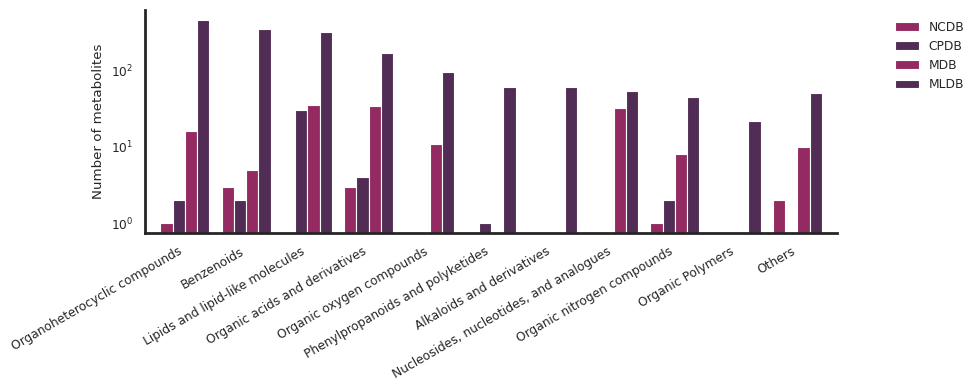

In [42]:
def prepare_absolute(data, df):
    nc_df = df[df['accession'].isin(data[0])]
    cp_df = df[df['accession'].isin(data[1])]
    me_df = df[df['accession'].isin(data[2])]
    ml_df = df[df['accession'].isin(data[3])]
    classes = df.columns[6:10]
    res = []
    for met_class in classes:
        fractions = pd.DataFrame()
        fractions['MetalinksDB'] = ml_df[met_class].value_counts()
        fractions['NeuronChatDB'] = nc_df[met_class].value_counts()
        fractions['CellphoneDB'] = cp_df[met_class].value_counts()
        fractions['MebocostDB'] = me_df[met_class].value_counts()
        s = fractions.sum(axis=1)
        fractions = fractions[s > 20]
        colsums = fractions.sum(axis=0)
        others = pd.DataFrame({'MetalinksDB': len(ml_df.index) -colsums['MetalinksDB'], 'NeuronChatDB': len(nc_df.index) - colsums['NeuronChatDB'], 'CellphoneDB': len(cp_df.index) - colsums['CellphoneDB'], 'MebocostDB': len(me_df.index) - colsums['MebocostDB']}, index=['Others'])
        fractions = fractions.append(others).fillna(0)
        res.append(fractions)

    return res

matrix = prepare_absolute(MR_metabolites, anno)
hm = matrix[1]
hm = hm[['NeuronChatDB', 'CellphoneDB', 'MebocostDB', 'MetalinksDB']]
hm.columns = ['NCDB', 'CPDB', 'MDB', 'MLDB']

# prepare grouped barplot from hm using seaborn
sns.set_style('white')
sns.set_context('paper')

fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#932A61', '#512D55']
sns.set_palette(colors)
hm.plot(kind='bar',  ax=ax, width=0.8)
ax.set_ylabel('Number of metabolites')
ax.set_xlabel('')
ax.set_yscale('log')
ax.set_xticklabels(hm.index, rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# rotate labels on x axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=False)
plt.tight_layout()
plt.show()
